# JointMatch SSL with EfficientNet on Tiny ImageNet

This notebook implements a Semi-Supervised Learning (SSL) strategy based on JointMatch, using an EfficientNet backbone trained on the Tiny ImageNet dataset. It incorporates concepts like adaptive thresholds, cross-labeling, and weighted disagreement updates.

**References:**
*   JointMatch Paper: [https://arxiv.org/abs/2310.15335](https://arxiv.org/abs/2310.15335) (Although the paper focuses on text, the core SSL ideas are adapted here for images).
*   FixMatch Paper (related baseline): [https://arxiv.org/abs/2001.07685](https://arxiv.org/abs/2001.07685)
*   EfficientNet-PyTorch: [https://github.com/lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch)

In [1]:
# 1. Install Necessary Packages
# Make sure efficientnet-pytorch is included
!pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets efficientnet-pytorch tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fc502b5e13fb2fe531650e968c5a2e5f3439f532ce9555a2cf9861035b317be4
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet-pyt

In [2]:
# 2. Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os
from random import randint
import urllib
import zipfile
import time
from tqdm.notebook import tqdm

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

# EfficientNet
from efficientnet_pytorch import EfficientNet

# Ignite (though we'll use a manual loop for more control over SSL specifics)
# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss
# from ignite.handlers import ModelCheckpoint, global_step_from_engine
# from ignite.contrib.handlers import ProgressBar, TensorboardLogger

# Define device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 3. Download and Prepare Tiny ImageNet Data
if not os.path.exists('tiny-imagenet-200.zip'):
    print("Downloading Tiny ImageNet...")
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
else:
    print("Zip file already downloaded.")

if not os.path.exists('tiny-imagenet-200'):
    print("Unzipping Tiny ImageNet...")
    !unzip -qq 'tiny-imagenet-200.zip'
    print("Unzipping complete.")
else:
    print("Dataset already unzipped.")

DATA_DIR = 'tiny-imagenet-200'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

# --- Validation Set Reorganization (Run only once) ---
val_anno_file = os.path.join(VALID_DIR, 'val_annotations.txt')
if os.path.exists(val_anno_file):
    print("Reorganizing validation set...")
    val_data = pd.read_csv(val_anno_file, sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
    val_img_dir = os.path.join(VALID_DIR, 'images')

    # Create dictionary to store img filename and corresponding label
    val_img_dict = {}
    for index, row in val_data.iterrows():
        val_img_dict[row['File']] = row['Class']

    # Create subfolders (if not present) for validation images based on label
    for img, folder in val_img_dict.items():
        newpath = os.path.join(val_img_dir, folder)
        if not os.path.exists(newpath):
            os.makedirs(newpath)

        img_path = os.path.join(val_img_dir, img)
        if os.path.exists(img_path):
            os.rename(img_path, os.path.join(newpath, img))

    # Remove the now empty 'images' folder if it exists and is empty
    # Also remove the annotation file to prevent re-running this block easily
    try:
        os.remove(val_anno_file)
        # Check if val_img_dir contains only directories (our class folders)
        is_empty_of_files = all(os.path.isdir(os.path.join(val_img_dir, entry)) for entry in os.listdir(val_img_dir))
        if is_empty_of_files and not os.listdir(val_img_dir): # Extra check if it became truly empty
             os.rmdir(val_img_dir)
        elif is_empty_of_files: # Contains class folders, which is expected
            print(f"Validation images moved to class folders within {val_img_dir}")
        else: # Contains unexpected files
             print(f"Warning: {val_img_dir} contains unexpected files after reorganization.")

    except OSError as e:
        print(f"Error removing file/dir during reorg cleanup: {e}")
    print("Validation set reorganization complete.")
else:
    print("Validation set likely already reorganized (val_annotations.txt not found).")

# Validation images are now inside VALID_DIR/{class_id}/images/*.JPEG
# Update VALID_DIR path to point to the parent of class folders
# VALID_DIR = os.path.join(VALID_DIR, 'images') # Incorrect: ImageFolder expects root/class/image.jpeg
# Keep VALID_DIR as 'tiny-imagenet-200/val'

# --- Get Class Names (Optional but helpful) ---
class_to_name_dict = {}
try:
    with open(os.path.join(DATA_DIR, 'words.txt'), 'r') as fp:
        data = fp.readlines()
    for line in data:
        words = line.strip('\n').split('\t')
        class_to_name_dict[words[0]] = words[1].split(',')[0]
except FileNotFoundError:
    print("words.txt not found, cannot map class IDs to names.")

--2025-04-13 09:08:34--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-04-13 09:08:35--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  7.49MB/s    in 48s     

2025-04-13 09:09:23 (4.96 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Unzipping Tiny ImageNet...
Unzipping complete.
Reorganizing validation set...
Validation images moved to class folders within tiny-imagenet-200/val/images
Validation set reorganiza

## 4. Data Transformations and Augmentations

For SSL (like FixMatch/JointMatch), we need:
1.  **Weak Augmentation:** Standard augmentations (like random crops, flips) applied to unlabeled data to generate pseudo-labels.
2.  **Strong Augmentation:** More aggressive augmentations (like RandAugment) applied to the *same* unlabeled data. The model is trained to predict the pseudo-label (from weak augmentation) even with strong augmentation.
3.  **Evaluation Transform:** A deterministic transform for the validation set (usually center crop).

We'll use a smaller input size (112x112) to manage memory with two models and gradient accumulation.

In [4]:
# ImageNet normalization stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Input size for the model (reduced for memory)
INPUT_SIZE = 112
RESIZE_SIZE = 128

# Weak Augmentation (for generating pseudo-labels and for labeled data training)
weak_transform = T.Compose([
    T.Resize(RESIZE_SIZE),
    T.RandomCrop(INPUT_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Strong Augmentation (for consistency regularization on unlabeled data)
strong_transform = T.Compose([
    T.Resize(RESIZE_SIZE),
    T.RandomCrop(INPUT_SIZE),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=10), # Added RandAugment
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transform for Validation/Evaluation (no random augmentation)
val_transform = T.Compose([
    T.Resize(RESIZE_SIZE),
    T.CenterCrop(INPUT_SIZE),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

## 5. Dataset Splitting and Custom Dataset Classes

We split the training data into a small labeled set and a large unlabeled set.

**Note:** The following cell sets up the dataset for a *single* labeled data fraction (e.g., 10 labeled examples per class). To test varying percentages (20%, 40%, etc.), you would need to re-run the splitting logic and the entire training process for each desired percentage.

In [5]:
# --- Helper function to split dataset --- 
def split_dataset(dataset, num_labeled_per_class, num_classes=200):
    # Make sure dataset.targets is accessible and correct
    try:
        targets = np.array(dataset.targets)
    except AttributeError:
        # If .targets isn't directly available, try accessing through samples
        # This assumes ImageFolder structure where samples is list of (filepath, target_idx)
        print("Accessing targets via dataset.samples")
        targets = np.array([s[1] for s in dataset.samples])
        if len(targets) != len(dataset):
             raise ValueError("Mismatch between length of samples and dataset length.")
    
    labeled_idx = []
    unlabeled_idx = []

    for c in range(num_classes):
        idx = np.where(targets == c)[0]
        if len(idx) == 0:
            print(f"Warning: No samples found for class {c}")
            continue
        np.random.shuffle(idx)
        # Ensure we don't request more labels than available for a class
        num_labeled_actual = min(num_labeled_per_class, len(idx))
        if num_labeled_actual < num_labeled_per_class:
            print(f"Warning: Class {c} only has {num_labeled_actual} samples, requested {num_labeled_per_class}. Using {num_labeled_actual}.")

        labeled_idx.extend(idx[:num_labeled_actual])
        unlabeled_idx.extend(idx[num_labeled_actual:])

    print(f"Total samples: {len(targets)}")
    print(f"Selected {len(labeled_idx)} labeled samples.")
    print(f"Using {len(unlabeled_idx)} unlabeled samples.")
    return labeled_idx, unlabeled_idx

# --- Custom Dataset Classes --- #

class LabeledDataset(Dataset):
    """Dataset wrapper for labeled data."""
    def __init__(self, dataset, indices, transform):
        # Create a Subset using the provided indices
        self.subset = Subset(dataset, indices)
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # Subset automatically handles the mapping from idx to the original dataset's index
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

class UnlabeledDataset(Dataset):
    """Dataset wrapper for unlabeled data. Returns weakly and strongly augmented views."""
    def __init__(self, dataset, indices, weak_transform, strong_transform):
        self.subset = Subset(dataset, indices)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, _ = self.subset[idx] # Ignore the label for unlabeled data
        weak_img = self.weak_transform(img)
        strong_img = self.strong_transform(img)
        return weak_img, strong_img

# --- Load the full training dataset (needed for splitting) --- #
print("Loading full training dataset for splitting...")
# Apply a minimal transform initially, real transforms are in the custom datasets
# ImageFolder needs *some* transform, even if just ToTensor or Lambda
# Using Lambda ensures the PIL image is passed to the Subset for later transformation
full_train_ds = datasets.ImageFolder(TRAIN_DIR, transform=T.Lambda(lambda x: x)) 
print(f"Full training dataset loaded with {len(full_train_ds)} samples.")
num_classes = len(full_train_ds.classes)
print(f"Number of classes detected: {num_classes}")

# --- Perform the split --- #
# Adjust this value to control the labeled data percentage
# Example: TinyImageNet has 100,000 training images, 500 per class (200 classes)
# 10 labels/class = 2000 labeled samples = 2% labeled data
# 50 labels/class = 10000 labeled samples = 10% labeled data
# 100 labels/class = 20000 labeled samples = 20% labeled data 
# etc.
NUM_LABELED_PER_CLASS = 10 # Change this for different experiments (e.g., 50 for 10%) 
labeled_indices, unlabeled_indices = split_dataset(full_train_ds, NUM_LABELED_PER_CLASS, num_classes)

# --- Create the Labeled and Unlabeled Datasets --- #
labeled_ds = LabeledDataset(full_train_ds, labeled_indices, transform=weak_transform)
unlabeled_ds = UnlabeledDataset(full_train_ds, unlabeled_indices, 
                                  weak_transform=weak_transform, 
                                  strong_transform=strong_transform)

# --- Create the Validation Dataset --- #
val_ds = datasets.ImageFolder(VALID_DIR, transform=val_transform)
print(f"Validation dataset loaded with {len(val_ds)} samples.")

# --- Define Batch Sizes and DataLoaders --- #
# Reduced batch sizes for memory management with two models + grad accum
LABELED_BATCH_SIZE = 32
MU = 1 # Ratio of unlabeled batch size to labeled batch size
UNLABELED_BATCH_SIZE = LABELED_BATCH_SIZE * MU
VAL_BATCH_SIZE = 64 # Can be larger as it's only used during evaluation

# Use num_workers > 0 if not debugging, speeds up data loading
num_workers = 2 if use_cuda else 0

labeled_loader = DataLoader(labeled_ds, 
                          batch_size=LABELED_BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=num_workers, 
                          pin_memory=True,
                          drop_last=True) # Drop last for consistent batch sizes

unlabeled_loader = DataLoader(unlabeled_ds, 
                            batch_size=UNLABELED_BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=num_workers, 
                            pin_memory=True,
                            drop_last=True)

val_loader = DataLoader(val_ds, 
                        batch_size=VAL_BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=num_workers, 
                        pin_memory=True)

print(f"DataLoaders created:")
print(f"  Labeled: {len(labeled_loader)} batches, size {LABELED_BATCH_SIZE}")
print(f"  Unlabeled: {len(unlabeled_loader)} batches, size {UNLABELED_BATCH_SIZE}")
print(f"  Validation: {len(val_loader)} batches, size {VAL_BATCH_SIZE}")

Loading full training dataset for splitting...
Full training dataset loaded with 100000 samples.
Number of classes detected: 200
Total samples: 100000
Selected 2000 labeled samples.
Using 98000 unlabeled samples.
Validation dataset loaded with 10000 samples.
DataLoaders created:
  Labeled: 62 batches, size 32
  Unlabeled: 3062 batches, size 32
  Validation: 157 batches, size 64


## 6. Model Definition (EfficientNet with Checkpointing)

We use two instances of EfficientNet-B0, pretrained on ImageNet. We wrap them in a `CheckpointWrapper` to save memory during training using gradient checkpointing.

In [6]:
# --- Gradient Checkpointing Wrapper --- #
# Helps save memory by trading compute time
class CheckpointWrapper(nn.Module):
    def __init__(self, module):
        super(CheckpointWrapper, self).__init__()
        self.module = module

    def forward(self, x):
        # Checkpointing expects inputs that require grad.
        # If input doesn't, wrap it, but don't make this permanent.
        requires_grad_state = x.requires_grad
        if not requires_grad_state:
             x = x.requires_grad_()

        # use_reentrant=False is generally recommended for newer PyTorch versions
        # Check PyTorch version for compatibility
        use_reentrant_arg = {} # Empty dict by default
        if torch.__version__ >= '1.11': # Example version check, adjust if needed
             use_reentrant_arg = {'use_reentrant': False}
             
        out = checkpoint.checkpoint(self.module, x, **use_reentrant_arg)

        # Restore original requires_grad state if we changed it
        # This might not be strictly necessary depending on subsequent ops,
        # but it's cleaner not to modify the input's state permanently.
        # However, detaching might break grad flow if needed later.
        # Let's rely on the checkpoint function handling it correctly and just return 'out'.
        # if not requires_grad_state:
        #      x.requires_grad_(False) # Revert - careful about side effects

        return out

# --- Function to create the EfficientNet model --- #
def get_efficientnet_model(num_classes=200, pretrained=True):
    model_name = 'efficientnet-b0'
    if pretrained:
        print(f"Loading pretrained {model_name}...")
        model = EfficientNet.from_pretrained(model_name)
    else:
        print(f"Loading {model_name} without pretrained weights...")
        model = EfficientNet.from_name(model_name)

    # Replace the classifier layer
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, num_classes)
    print(f"Replaced final layer for {num_classes} classes.")
    return model

# --- Create the two models with checkpointing --- #
print("Creating Model F...")
model_f = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes)).to(device)
print("\nCreating Model G...")
model_g = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes)).to(device)

# --- Optimizers --- #
# Using AdamW which is often preferred for Transformers and modern CNNs
LEARNING_RATE = 1e-4 # Lower learning rate for fine-tuning
WEIGHT_DECAY = 1e-4

optimizer_f = optim.AdamW(model_f.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer_g = optim.AdamW(model_g.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# --- Learning Rate Scheduler (Optional but recommended) --- #
# Cosine annealing is a popular choice
scheduler_f = optim.lr_scheduler.CosineAnnealingLR(optimizer_f, T_max=len(labeled_loader) * 100) # T_max = steps per epoch * num_epochs
scheduler_g = optim.lr_scheduler.CosineAnnealingLR(optimizer_g, T_max=len(labeled_loader) * 100)


Creating Model F...
Loading pretrained efficientnet-b0...


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 24.5MB/s]


Loaded pretrained weights for efficientnet-b0
Replaced final layer for 200 classes.

Creating Model G...
Loading pretrained efficientnet-b0...
Loaded pretrained weights for efficientnet-b0
Replaced final layer for 200 classes.


## 7. JointMatch Training Setup

Define hyperparameters and initialize necessary components for the JointMatch algorithm.

In [7]:
# --- JointMatch Hyperparameters --- #
W_U = 1.0             # Unsupervised loss weight (lambda_u in FixMatch/JointMatch)
EMA_DECAY = 0.99      # Exponential Moving Average decay for class probability estimates
FIXED_TAU = 0.95      # Fixed confidence threshold (base value)
DELTA = 0.9           # Disagreement weight (controls emphasis on disagreement vs agreement)
NUM_EPOCHS = 100      # Total training epochs
MAX_GRAD_NORM = 1.0   # Gradient clipping threshold

# --- Gradient Accumulation --- #
# Accumulate gradients over N steps before optimizer step
# Reduces memory usage at the cost of slower effective batch updates
ACCUMULATION_STEPS = 8 # Adjust based on GPU memory (effective batch size = BATCH_SIZE * ACCUMULATION_STEPS)
print(f"Gradient Accumulation Steps: {ACCUMULATION_STEPS}")
print(f"Effective Labeled Batch Size: {LABELED_BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"Effective Unlabeled Batch Size: {UNLABELED_BATCH_SIZE * ACCUMULATION_STEPS}")

# --- Automatic Mixed Precision (AMP) Scalers --- #
# Use 'enabled=use_cuda' to automatically disable AMP on CPU
scaler_f = torch.cuda.amp.GradScaler(enabled=use_cuda)
scaler_g = torch.cuda.amp.GradScaler(enabled=use_cuda)

# --- EMA for Class Predictions (p_tilde) --- #
# Initialize average predicted probability per class uniformly
# Used for adaptive threshold calculation
p_tilde_f = torch.ones(num_classes, device=device) / num_classes
p_tilde_g = torch.ones(num_classes, device=device) / num_classes

# --- Checkpoint Directory --- #
CHECKPOINT_DIR = "jointmatch_efficientnet_checkpoints"
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
    print(f"Created checkpoint directory: {CHECKPOINT_DIR}")

# --- Metrics Storage --- #
train_losses_sup_f = []
train_losses_sup_g = []
train_losses_unsup_f = []
train_losses_unsup_g = []
train_losses_total_f = []
train_losses_total_g = []
val_losses_f = [] # Added to store validation loss for F
val_losses_g = [] # Added to store validation loss for G
val_accuracies_f = []
val_accuracies_g = []
val_accuracies_avg = []
best_val_acc_avg = 0.0

Gradient Accumulation Steps: 8
Effective Labeled Batch Size: 256
Effective Unlabeled Batch Size: 256
Created checkpoint directory: jointmatch_efficientnet_checkpoints


/tmp/ipykernel_19/312277983.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_f = torch.cuda.amp.GradScaler(enabled=use_cuda)
/tmp/ipykernel_19/312277983.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_g = torch.cuda.amp.GradScaler(enabled=use_cuda)


## 8. Evaluation Function

In [8]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            # Use AMP for evaluation inference as well (can speed things up)
            with torch.amp.autocast(device_type=device.type, enabled=use_cuda):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            pbar.set_postfix(acc=f"{(correct/total)*100:.2f}%")

    avg_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return avg_loss, accuracy

## 9. JointMatch Training Loop

This loop performs the JointMatch training. It includes:
- Supervised loss calculation on labeled data.
- Pseudo-label generation using weak augmentations and adaptive thresholds.
- Cross-labeling (Model F uses G's pseudo-labels, Model G uses F's).
- Disagreement weighting.
- Unsupervised consistency loss calculation using strong augmentations.
- Gradient accumulation and AMP for efficiency.
- Periodic evaluation and saving of the best models based on average validation accuracy.

In [9]:
# --- Loss Function (standard Cross Entropy) --- #
ce_loss = nn.CrossEntropyLoss()
ce_loss_reduction_none = nn.CrossEntropyLoss(reduction='none') # For manual weighting

# --- Training Loop --- #
print("Starting JointMatch Training...")
start_time = time.time()

# Initialize best accuracy to handle potential loading from checkpoint later (optional)
# best_val_acc_avg = 0.0 
# TODO: Add logic here to load best_val_acc_avg if resuming training

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    model_f.train()
    model_g.train()

    # Use iterators for flexibility with different dataset lengths
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)

    # Determine number of steps based on the longer loader (usually unlabeled if mu > 1)
    # Since mu=1 and drop_last=True, they have the same length here.
    num_steps = len(labeled_loader)

    running_loss_sup_f, running_loss_unsup_f, running_loss_total_f = 0.0, 0.0, 0.0
    running_loss_sup_g, running_loss_unsup_g, running_loss_total_g = 0.0, 0.0, 0.0
    pseudo_labels_used_f, pseudo_labels_correct_f = 0, 0  # Track pseudo-label stats (optional)
    pseudo_labels_used_g, pseudo_labels_correct_g = 0, 0
    mask_sum_f, mask_sum_g = 0, 0

    # Manually handle optimizer zero_grad with accumulation
    optimizer_f.zero_grad()
    optimizer_g.zero_grad()

    pbar = tqdm(range(num_steps), desc=f"Epoch {epoch+1} Training")

    for step in pbar:
        try:
            l_imgs, labels = next(labeled_iter)
        except StopIteration:
            # Should not happen with drop_last=True and equal lengths
            labeled_iter = iter(labeled_loader)
            l_imgs, labels = next(labeled_iter)

        try:
            weak_imgs, strong_imgs = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            weak_imgs, strong_imgs = next(unlabeled_iter)

        l_imgs, labels = l_imgs.to(device), labels.to(device)
        weak_imgs, strong_imgs = weak_imgs.to(device), strong_imgs.to(device)

        # Forward passes with AMP context manager
        with torch.amp.autocast(device_type=device.type, enabled=use_cuda):
            # 1. Supervised Loss (Labeled Data)
            logits_f_sup = model_f(l_imgs)
            logits_g_sup = model_g(l_imgs)
            sup_loss_f = ce_loss(logits_f_sup, labels)
            sup_loss_g = ce_loss(logits_g_sup, labels)

            # 2. Pseudo-Label Generation (Unlabeled Data - Weak Augmentation)
            # No gradient needed for pseudo-label generation
            with torch.no_grad():
                logits_f_weak = model_f(weak_imgs)
                logits_g_weak = model_g(weak_imgs)
                probs_f_weak = F.softmax(logits_f_weak, dim=1)
                probs_g_weak = F.softmax(logits_g_weak, dim=1)

                # Update EMA of class probabilities (p_tilde)
                # Detach probabilities before EMA update
                p_tilde_f = EMA_DECAY * p_tilde_f + (1 - EMA_DECAY) * probs_f_weak.mean(dim=0).detach()
                p_tilde_g = EMA_DECAY * p_tilde_g + (1 - EMA_DECAY) * probs_g_weak.mean(dim=0).detach()

                # Calculate Adaptive Thresholds (tau_t)
                # Clamp to avoid division by zero if max is 0 (unlikely with EMA)
                tau_t_f = FIXED_TAU * (p_tilde_f / torch.max(p_tilde_f, torch.tensor(1e-6).to(device)))
                tau_t_g = FIXED_TAU * (p_tilde_g / torch.max(p_tilde_g, torch.tensor(1e-6).to(device)))

                # Generate Pseudo-Labels and Masks (Cross-Labeling)
                # Model F uses pseudo-labels from Model G
                max_probs_g, pseudo_labels_g = torch.max(probs_g_weak, dim=1)
                thresholds_g = tau_t_g[pseudo_labels_g] # Get threshold for the predicted class
                mask_f = max_probs_g.ge(thresholds_g)   # Mask where confidence >= threshold

                # Model G uses pseudo-labels from Model F
                max_probs_f, pseudo_labels_f = torch.max(probs_f_weak, dim=1)
                thresholds_f = tau_t_f[pseudo_labels_f]
                mask_g = max_probs_f.ge(thresholds_f)

                # Disagreement Weights (w_b in paper notation)
                pred_f_hard = torch.argmax(probs_f_weak, dim=1)
                pred_g_hard = torch.argmax(probs_g_weak, dim=1)

                disagreement_mask = pred_f_hard.ne(pred_g_hard)
                agreement_mask = pred_f_hard.eq(pred_g_hard)

                # Weights for model F's unsupervised loss (using G's pseudo-labels)
                weights_f = torch.where(disagreement_mask,
                                        torch.tensor(DELTA, device=device),
                                        torch.tensor(1 - DELTA, device=device))

                # Weights for model G's unsupervised loss (using F's pseudo-labels)
                weights_g = torch.where(disagreement_mask,
                                        torch.tensor(DELTA, device=device),
                                        torch.tensor(1 - DELTA, device=device))

            # 3. Unsupervised Loss (Unlabeled Data - Strong Augmentation)
            logits_f_strong = model_f(strong_imgs)
            logits_g_strong = model_g(strong_imgs)

            # Calculate unsupervised loss for model F (using G's labels)
            if mask_f.any(): # Use .any() for boolean tensor check
                unsup_loss_f_elementwise = ce_loss_reduction_none(logits_f_strong[mask_f], pseudo_labels_g[mask_f])
                unsup_loss_f = (weights_f[mask_f] * unsup_loss_f_elementwise).mean()
            else:
                unsup_loss_f = torch.tensor(0.0, device=device)

            # Calculate unsupervised loss for model G (using F's labels)
            if mask_g.any():
                unsup_loss_g_elementwise = ce_loss_reduction_none(logits_g_strong[mask_g], pseudo_labels_f[mask_g])
                unsup_loss_g = (weights_g[mask_g] * unsup_loss_g_elementwise).mean()
            else:
                unsup_loss_g = torch.tensor(0.0, device=device)

            # 4. Total Loss
            # Normalize by accumulation steps to keep loss magnitude consistent
            total_loss_f = (sup_loss_f + W_U * unsup_loss_f) / ACCUMULATION_STEPS
            total_loss_g = (sup_loss_g + W_U * unsup_loss_g) / ACCUMULATION_STEPS

        # Backward pass with scaler for AMP
        # Check for non-finite losses before backward
        if not torch.isfinite(total_loss_f) or not torch.isfinite(total_loss_g):
            print(f"\nWarning: Non-finite loss detected at Epoch {epoch+1}, Step {step+1}. Skipping step.")
            print(f"Loss F: {total_loss_f.item()}, Loss G: {total_loss_g.item()}")
            # Need to zero grads accumulated so far for this step if skipping
            optimizer_f.zero_grad()
            optimizer_g.zero_grad()
            continue

        scaler_f.scale(total_loss_f).backward()
        scaler_g.scale(total_loss_g).backward()

        # Accumulate running losses (use original scale)
        running_loss_sup_f += sup_loss_f.item()
        running_loss_unsup_f += unsup_loss_f.item() if torch.is_tensor(unsup_loss_f) else unsup_loss_f # Handle case where unsup_loss is 0.0 float
        running_loss_total_f += total_loss_f.item() * ACCUMULATION_STEPS # Multiply back accum steps
        running_loss_sup_g += sup_loss_g.item()
        running_loss_unsup_g += unsup_loss_g.item() if torch.is_tensor(unsup_loss_g) else unsup_loss_g
        running_loss_total_g += total_loss_g.item() * ACCUMULATION_STEPS
        mask_sum_f += mask_f.float().sum().item()
        mask_sum_g += mask_g.float().sum().item()

        # --- Optimizer Step after Accumulation --- #
        if (step + 1) % ACCUMULATION_STEPS == 0:
            # Unscale gradients and clip
            scaler_f.unscale_(optimizer_f)
            torch.nn.utils.clip_grad_norm_(model_f.parameters(), MAX_GRAD_NORM)
            scaler_g.unscale_(optimizer_g)
            torch.nn.utils.clip_grad_norm_(model_g.parameters(), MAX_GRAD_NORM)

            # Optimizer step
            scaler_f.step(optimizer_f)
            scaler_g.step(optimizer_g)

            # Update scaler
            scaler_f.update()
            scaler_g.update()

            # Zero gradients for the next accumulation cycle
            optimizer_f.zero_grad()
            optimizer_g.zero_grad()

            # Step LR scheduler (optional, depends on schedule type)
            # If using CosineAnnealingLR, step every optimizer step
            if scheduler_f: scheduler_f.step()
            if scheduler_g: scheduler_g.step()

        # Update progress bar
        # Calculate avg losses for display more frequently if needed
        current_avg_loss_f = running_loss_total_f / (step + 1)
        current_avg_loss_g = running_loss_total_g / (step + 1)
        current_mask_f_avg = mask_sum_f / ((step+1) * UNLABELED_BATCH_SIZE) if (step+1) > 0 else 0
        current_mask_g_avg = mask_sum_g / ((step+1) * UNLABELED_BATCH_SIZE) if (step+1) > 0 else 0

        pbar.set_postfix(avg_loss_f=f"{current_avg_loss_f:.3f}",
                         avg_loss_g=f"{current_avg_loss_g:.3f}",
                         mask_f=f"{current_mask_f_avg:.2f}",
                         mask_g=f"{current_mask_g_avg:.2f}",
                         lr_f=f"{optimizer_f.param_groups[0]['lr']:.1E}",
                         lr_g=f"{optimizer_g.param_groups[0]['lr']:.1E}")

        # Clean up memory (moved inside loop to potentially help more)
        del l_imgs, labels, weak_imgs, strong_imgs, logits_f_sup, logits_g_sup, \
            logits_f_weak, logits_g_weak, probs_f_weak, probs_g_weak, \
            logits_f_strong, logits_g_strong, sup_loss_f, sup_loss_g, unsup_loss_f, unsup_loss_g, \
            total_loss_f, total_loss_g, mask_f, mask_g, weights_f, weights_g
        if use_cuda: torch.cuda.empty_cache()

    # --- End of Epoch --- #
    epoch_duration = time.time() - epoch_start_time

    # Calculate average losses for the epoch
    avg_loss_sup_f = running_loss_sup_f / num_steps
    avg_loss_unsup_f = running_loss_unsup_f / num_steps if num_steps > 0 else 0 # Avoid division by zero
    avg_loss_total_f = running_loss_total_f / num_steps
    avg_loss_sup_g = running_loss_sup_g / num_steps
    avg_loss_unsup_g = running_loss_unsup_g / num_steps if num_steps > 0 else 0
    avg_loss_total_g = running_loss_total_g / num_steps
    avg_mask_f = mask_sum_f / (num_steps * UNLABELED_BATCH_SIZE) if num_steps > 0 else 0
    avg_mask_g = mask_sum_g / (num_steps * UNLABELED_BATCH_SIZE) if num_steps > 0 else 0

    train_losses_sup_f.append(avg_loss_sup_f)
    train_losses_unsup_f.append(avg_loss_unsup_f)
    train_losses_total_f.append(avg_loss_total_f)
    train_losses_sup_g.append(avg_loss_sup_g)
    train_losses_unsup_g.append(avg_loss_unsup_g)
    train_losses_total_g.append(avg_loss_total_g)

    print(f"Epoch {epoch+1} Summary:")
    print(f"  Duration: {epoch_duration:.2f}s")
    print(f"  Avg Loss F: Total={avg_loss_total_f:.4f} (Sup={avg_loss_sup_f:.4f}, Unsup={avg_loss_unsup_f:.4f}) Mask={avg_mask_f:.3f}")
    print(f"  Avg Loss G: Total={avg_loss_total_g:.4f} (Sup={avg_loss_sup_g:.4f}, Unsup={avg_loss_unsup_g:.4f}) Mask={avg_mask_g:.3f}")

    # Evaluate on validation set
    print("Evaluating Model F...")
    val_loss_f, val_acc_f = evaluate(model_f, val_loader, ce_loss)
    print(f"  Model F Val Loss: {val_loss_f:.4f}, Val Acc: {val_acc_f*100:.2f}%")
    print("Evaluating Model G...")
    val_loss_g, val_acc_g = evaluate(model_g, val_loader, ce_loss)
    print(f"  Model G Val Loss: {val_loss_g:.4f}, Val Acc: {val_acc_g*100:.2f}%")

    # Store validation metrics
    val_losses_f.append(val_loss_f)
    val_losses_g.append(val_loss_g)
    val_accuracies_f.append(val_acc_f)
    val_accuracies_g.append(val_acc_g)
    avg_val_acc = (val_acc_f + val_acc_g) / 2.0
    val_accuracies_avg.append(avg_val_acc)
    print(f"  Average Val Acc: {avg_val_acc*100:.2f}%")

    # Save checkpoint (best model based on average accuracy)
    if avg_val_acc > best_val_acc_avg:
        best_val_acc_avg = avg_val_acc
        # Save state dicts (.pth is a common convention, .pt is also fine)
        best_model_f_path = os.path.join(CHECKPOINT_DIR, "best_model_f.pth")
        best_model_g_path = os.path.join(CHECKPOINT_DIR, "best_model_g.pth")
        torch.save(model_f.state_dict(), best_model_f_path)
        torch.save(model_g.state_dict(), best_model_g_path)
        # Optionally save optimizers and schedulers if you want to resume training
        # torch.save(optimizer_f.state_dict(), os.path.join(CHECKPOINT_DIR, "best_optimizer_f.pt"))
        # torch.save(optimizer_g.state_dict(), os.path.join(CHECKPOINT_DIR, "best_optimizer_g.pt"))
        # if scheduler_f: torch.save(scheduler_f.state_dict(), os.path.join(CHECKPOINT_DIR, "best_scheduler_f.pt"))
        # if scheduler_g: torch.save(scheduler_g.state_dict(), os.path.join(CHECKPOINT_DIR, "best_scheduler_g.pt"))
        print(f"*** New best average validation accuracy: {avg_val_acc*100:.2f}%. Best model state dicts saved to {best_model_f_path} and {best_model_g_path} ***")

    # Save checkpoint for the current epoch (optional, useful for debugging)
    # epoch_save_path_f = os.path.join(CHECKPOINT_DIR, f"model_f_epoch{epoch+1}.pth")
    # epoch_save_path_g = os.path.join(CHECKPOINT_DIR, f"model_g_epoch{epoch+1}.pth")
    # torch.save(model_f.state_dict(), epoch_save_path_f)
    # torch.save(model_g.state_dict(), epoch_save_path_g)
    # print(f"Epoch {epoch+1} models saved to {epoch_save_path_f} and {epoch_save_path_g}")

    if use_cuda: torch.cuda.empty_cache()

total_training_time = time.time() - start_time
print(f"\n--- Training Finished --- ")
print(f"Total Training Time: {total_training_time/3600:.2f} hours")
print(f"Best Average Validation Accuracy: {best_val_acc_avg*100:.2f}%")

Starting JointMatch Training...

--- Epoch 1/100 ---


Epoch 1 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1 Summary:
  Duration: 19.94s
  Avg Loss F: Total=5.3227 (Sup=5.3227, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.3237 (Sup=5.3237, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3876, Val Acc: 0.19%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3766, Val Acc: 0.33%
  Average Val Acc: 0.26%
*** New best average validation accuracy: 0.26%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 2/100 ---


Epoch 2 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2 Summary:
  Duration: 18.76s
  Avg Loss F: Total=5.2427 (Sup=5.2427, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.2520 (Sup=5.2520, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3819, Val Acc: 0.25%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4004, Val Acc: 0.23%
  Average Val Acc: 0.24%

--- Epoch 3/100 ---


Epoch 3 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3 Summary:
  Duration: 18.78s
  Avg Loss F: Total=5.1757 (Sup=5.1757, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.1701 (Sup=5.1701, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3827, Val Acc: 0.22%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4108, Val Acc: 0.20%
  Average Val Acc: 0.21%

--- Epoch 4/100 ---


Epoch 4 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4 Summary:
  Duration: 18.87s
  Avg Loss F: Total=5.0962 (Sup=5.0962, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.1038 (Sup=5.1038, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3816, Val Acc: 0.24%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4085, Val Acc: 0.23%
  Average Val Acc: 0.23%

--- Epoch 5/100 ---


Epoch 5 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5 Summary:
  Duration: 18.97s
  Avg Loss F: Total=5.0309 (Sup=5.0309, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.0322 (Sup=5.0322, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3885, Val Acc: 0.20%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4217, Val Acc: 0.22%
  Average Val Acc: 0.21%

--- Epoch 6/100 ---


Epoch 6 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 6 Summary:
  Duration: 18.75s
  Avg Loss F: Total=4.9478 (Sup=4.9478, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.9461 (Sup=4.9461, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3938, Val Acc: 0.19%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4208, Val Acc: 0.26%
  Average Val Acc: 0.22%

--- Epoch 7/100 ---


Epoch 7 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 7 Summary:
  Duration: 18.86s
  Avg Loss F: Total=4.8745 (Sup=4.8745, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.8702 (Sup=4.8702, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3986, Val Acc: 0.18%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4252, Val Acc: 0.25%
  Average Val Acc: 0.21%

--- Epoch 8/100 ---


Epoch 8 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 8 Summary:
  Duration: 18.86s
  Avg Loss F: Total=4.7948 (Sup=4.7948, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.7954 (Sup=4.7954, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4103, Val Acc: 0.17%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4355, Val Acc: 0.28%
  Average Val Acc: 0.22%

--- Epoch 9/100 ---


Epoch 9 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 9 Summary:
  Duration: 18.60s
  Avg Loss F: Total=4.7143 (Sup=4.7143, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.6972 (Sup=4.6972, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4124, Val Acc: 0.17%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4538, Val Acc: 0.30%
  Average Val Acc: 0.24%

--- Epoch 10/100 ---


Epoch 10 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 10 Summary:
  Duration: 18.91s
  Avg Loss F: Total=4.6208 (Sup=4.6208, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.6123 (Sup=4.6123, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4111, Val Acc: 0.20%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4611, Val Acc: 0.42%
  Average Val Acc: 0.31%
*** New best average validation accuracy: 0.31%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 11/100 ---


Epoch 11 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 11 Summary:
  Duration: 18.91s
  Avg Loss F: Total=4.5315 (Sup=4.5315, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.5414 (Sup=4.5414, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4251, Val Acc: 0.19%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4732, Val Acc: 0.48%
  Average Val Acc: 0.33%
*** New best average validation accuracy: 0.33%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 12/100 ---


Epoch 12 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 12 Summary:
  Duration: 18.80s
  Avg Loss F: Total=4.4355 (Sup=4.4355, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.4349 (Sup=4.4349, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4301, Val Acc: 0.24%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4968, Val Acc: 0.45%
  Average Val Acc: 0.34%
*** New best average validation accuracy: 0.34%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 13/100 ---


Epoch 13 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 13 Summary:
  Duration: 19.04s
  Avg Loss F: Total=4.3321 (Sup=4.3321, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.3382 (Sup=4.3382, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4382, Val Acc: 0.28%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5075, Val Acc: 0.58%
  Average Val Acc: 0.43%
*** New best average validation accuracy: 0.43%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 14/100 ---


Epoch 14 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 14 Summary:
  Duration: 19.14s
  Avg Loss F: Total=4.2302 (Sup=4.2302, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.2241 (Sup=4.2241, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4551, Val Acc: 0.33%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5245, Val Acc: 0.56%
  Average Val Acc: 0.45%
*** New best average validation accuracy: 0.45%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 15/100 ---


Epoch 15 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 15 Summary:
  Duration: 18.86s
  Avg Loss F: Total=4.1276 (Sup=4.1276, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.1194 (Sup=4.1194, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4641, Val Acc: 0.36%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5406, Val Acc: 0.60%
  Average Val Acc: 0.48%
*** New best average validation accuracy: 0.48%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 16/100 ---


Epoch 16 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 16 Summary:
  Duration: 18.90s
  Avg Loss F: Total=4.0153 (Sup=4.0153, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.0121 (Sup=4.0121, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4788, Val Acc: 0.40%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5698, Val Acc: 0.56%
  Average Val Acc: 0.48%

--- Epoch 17/100 ---


Epoch 17 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 17 Summary:
  Duration: 18.91s
  Avg Loss F: Total=3.8992 (Sup=3.8992, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.9004 (Sup=3.9004, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4946, Val Acc: 0.45%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5936, Val Acc: 0.60%
  Average Val Acc: 0.52%
*** New best average validation accuracy: 0.52%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 18/100 ---


Epoch 18 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 18 Summary:
  Duration: 19.09s
  Avg Loss F: Total=3.7719 (Sup=3.7719, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.7691 (Sup=3.7691, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.5180, Val Acc: 0.45%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.6217, Val Acc: 0.49%
  Average Val Acc: 0.47%

--- Epoch 19/100 ---


Epoch 19 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 19 Summary:
  Duration: 18.86s
  Avg Loss F: Total=3.6437 (Sup=3.6437, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.6642 (Sup=3.6642, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.5416, Val Acc: 0.47%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.6540, Val Acc: 0.53%
  Average Val Acc: 0.50%

--- Epoch 20/100 ---


Epoch 20 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 20 Summary:
  Duration: 18.98s
  Avg Loss F: Total=3.5268 (Sup=3.5268, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.5474 (Sup=3.5474, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.5692, Val Acc: 0.47%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.6851, Val Acc: 0.55%
  Average Val Acc: 0.51%

--- Epoch 21/100 ---


Epoch 21 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 21 Summary:
  Duration: 19.06s
  Avg Loss F: Total=3.4009 (Sup=3.4009, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.4407 (Sup=3.4407, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.5865, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.7070, Val Acc: 0.55%
  Average Val Acc: 0.54%
*** New best average validation accuracy: 0.54%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 22/100 ---


Epoch 22 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 22 Summary:
  Duration: 19.02s
  Avg Loss F: Total=3.2987 (Sup=3.2987, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.3217 (Sup=3.3217, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.6234, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.7458, Val Acc: 0.55%
  Average Val Acc: 0.55%
*** New best average validation accuracy: 0.55%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 23/100 ---


Epoch 23 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 23 Summary:
  Duration: 18.98s
  Avg Loss F: Total=3.1722 (Sup=3.1722, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.1986 (Sup=3.1986, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.6615, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.7808, Val Acc: 0.56%
  Average Val Acc: 0.55%
*** New best average validation accuracy: 0.55%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 24/100 ---


Epoch 24 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 24 Summary:
  Duration: 19.10s
  Avg Loss F: Total=3.0651 (Sup=3.0651, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.1138 (Sup=3.1138, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.7003, Val Acc: 0.57%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.8190, Val Acc: 0.55%
  Average Val Acc: 0.56%
*** New best average validation accuracy: 0.56%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 25/100 ---


Epoch 25 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 25 Summary:
  Duration: 19.60s
  Avg Loss F: Total=2.9592 (Sup=2.9592, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.0054 (Sup=3.0054, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.7212, Val Acc: 0.61%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.8391, Val Acc: 0.58%
  Average Val Acc: 0.60%
*** New best average validation accuracy: 0.60%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 26/100 ---


Epoch 26 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 26 Summary:
  Duration: 19.75s
  Avg Loss F: Total=2.8330 (Sup=2.8330, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.8913 (Sup=2.8909, Unsup=0.0004) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.7736, Val Acc: 0.57%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.8788, Val Acc: 0.57%
  Average Val Acc: 0.57%

--- Epoch 27/100 ---


Epoch 27 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 27 Summary:
  Duration: 19.05s
  Avg Loss F: Total=2.7183 (Sup=2.7183, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.7672 (Sup=2.7666, Unsup=0.0006) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.8115, Val Acc: 0.64%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.9199, Val Acc: 0.63%
  Average Val Acc: 0.64%
*** New best average validation accuracy: 0.64%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 28/100 ---


Epoch 28 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 28 Summary:
  Duration: 19.23s
  Avg Loss F: Total=2.6392 (Sup=2.6392, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.6822 (Sup=2.6822, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.8478, Val Acc: 0.61%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.9488, Val Acc: 0.59%
  Average Val Acc: 0.60%

--- Epoch 29/100 ---


Epoch 29 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 29 Summary:
  Duration: 19.46s
  Avg Loss F: Total=2.5423 (Sup=2.5423, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.5784 (Sup=2.5784, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.8765, Val Acc: 0.66%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.9574, Val Acc: 0.65%
  Average Val Acc: 0.66%
*** New best average validation accuracy: 0.66%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 30/100 ---


Epoch 30 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 30 Summary:
  Duration: 19.29s
  Avg Loss F: Total=2.4345 (Sup=2.4345, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.4613 (Sup=2.4613, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.9208, Val Acc: 0.66%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.9957, Val Acc: 0.67%
  Average Val Acc: 0.66%
*** New best average validation accuracy: 0.66%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 31/100 ---


Epoch 31 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 31 Summary:
  Duration: 18.81s
  Avg Loss F: Total=2.3406 (Sup=2.3406, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.4056 (Sup=2.4056, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.9614, Val Acc: 0.67%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.0264, Val Acc: 0.71%
  Average Val Acc: 0.69%
*** New best average validation accuracy: 0.69%. Best model state dicts saved to jointmatch_efficientnet_checkpoints/best_model_f.pth and jointmatch_efficientnet_checkpoints/best_model_g.pth ***

--- Epoch 32/100 ---


Epoch 32 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 32 Summary:
  Duration: 19.21s
  Avg Loss F: Total=2.2330 (Sup=2.2330, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.2759 (Sup=2.2759, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.0405, Val Acc: 0.66%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.0767, Val Acc: 0.63%
  Average Val Acc: 0.65%

--- Epoch 33/100 ---


Epoch 33 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 33 Summary:
  Duration: 19.17s
  Avg Loss F: Total=2.1547 (Sup=2.1547, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.2022 (Sup=2.2022, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.0753, Val Acc: 0.64%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.1174, Val Acc: 0.67%
  Average Val Acc: 0.66%

--- Epoch 34/100 ---


Epoch 34 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 34 Summary:
  Duration: 19.10s
  Avg Loss F: Total=2.0535 (Sup=2.0535, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.1000 (Sup=2.1000, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.1199, Val Acc: 0.65%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.1656, Val Acc: 0.67%
  Average Val Acc: 0.66%

--- Epoch 35/100 ---


Epoch 35 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 35 Summary:
  Duration: 18.96s
  Avg Loss F: Total=1.9758 (Sup=1.9758, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.0220 (Sup=2.0220, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.1775, Val Acc: 0.64%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.2203, Val Acc: 0.68%
  Average Val Acc: 0.66%

--- Epoch 36/100 ---


Epoch 36 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 36 Summary:
  Duration: 19.41s
  Avg Loss F: Total=1.8673 (Sup=1.8673, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.8913 (Sup=1.8911, Unsup=0.0002) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.2067, Val Acc: 0.63%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.2321, Val Acc: 0.72%
  Average Val Acc: 0.68%

--- Epoch 37/100 ---


Epoch 37 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 37 Summary:
  Duration: 18.90s
  Avg Loss F: Total=1.8031 (Sup=1.8028, Unsup=0.0003) Mask=0.001
  Avg Loss G: Total=1.8354 (Sup=1.8354, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.2936, Val Acc: 0.61%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.2911, Val Acc: 0.70%
  Average Val Acc: 0.66%

--- Epoch 38/100 ---


Epoch 38 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 38 Summary:
  Duration: 19.06s
  Avg Loss F: Total=1.7145 (Sup=1.7145, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.7533 (Sup=1.7533, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.3427, Val Acc: 0.59%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.3427, Val Acc: 0.64%
  Average Val Acc: 0.61%

--- Epoch 39/100 ---


Epoch 39 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 39 Summary:
  Duration: 18.94s
  Avg Loss F: Total=1.6600 (Sup=1.6600, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.7062 (Sup=1.7062, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.3720, Val Acc: 0.58%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.3872, Val Acc: 0.66%
  Average Val Acc: 0.62%

--- Epoch 40/100 ---


Epoch 40 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 40 Summary:
  Duration: 18.97s
  Avg Loss F: Total=1.5688 (Sup=1.5688, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.6045 (Sup=1.6045, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.4135, Val Acc: 0.58%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.4105, Val Acc: 0.65%
  Average Val Acc: 0.61%

--- Epoch 41/100 ---


Epoch 41 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 41 Summary:
  Duration: 19.49s
  Avg Loss F: Total=1.5026 (Sup=1.5025, Unsup=0.0001) Mask=0.001
  Avg Loss G: Total=1.5272 (Sup=1.5270, Unsup=0.0001) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.4724, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.4724, Val Acc: 0.62%
  Average Val Acc: 0.57%

--- Epoch 42/100 ---


Epoch 42 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 42 Summary:
  Duration: 19.30s
  Avg Loss F: Total=1.4307 (Sup=1.4307, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.4713 (Sup=1.4713, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.5273, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.5216, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 43/100 ---


Epoch 43 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 43 Summary:
  Duration: 19.02s
  Avg Loss F: Total=1.3704 (Sup=1.3704, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.3861 (Sup=1.3861, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.5532, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.5669, Val Acc: 0.59%
  Average Val Acc: 0.55%

--- Epoch 44/100 ---


Epoch 44 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 44 Summary:
  Duration: 19.21s
  Avg Loss F: Total=1.3053 (Sup=1.3043, Unsup=0.0010) Mask=0.001
  Avg Loss G: Total=1.3333 (Sup=1.3330, Unsup=0.0003) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.6324, Val Acc: 0.48%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.6411, Val Acc: 0.56%
  Average Val Acc: 0.52%

--- Epoch 45/100 ---


Epoch 45 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 45 Summary:
  Duration: 18.97s
  Avg Loss F: Total=1.2166 (Sup=1.2166, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.2330 (Sup=1.2330, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.6350, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.6349, Val Acc: 0.64%
  Average Val Acc: 0.60%

--- Epoch 46/100 ---


Epoch 46 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 46 Summary:
  Duration: 19.08s
  Avg Loss F: Total=1.1568 (Sup=1.1568, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.1866 (Sup=1.1866, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.7018, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.6743, Val Acc: 0.62%
  Average Val Acc: 0.57%

--- Epoch 47/100 ---


Epoch 47 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 47 Summary:
  Duration: 18.91s
  Avg Loss F: Total=1.1094 (Sup=1.1094, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.1410 (Sup=1.1410, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.7518, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.7345, Val Acc: 0.62%
  Average Val Acc: 0.58%

--- Epoch 48/100 ---


Epoch 48 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 48 Summary:
  Duration: 19.37s
  Avg Loss F: Total=1.0362 (Sup=1.0361, Unsup=0.0002) Mask=0.001
  Avg Loss G: Total=1.0759 (Sup=1.0735, Unsup=0.0024) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.7780, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.7715, Val Acc: 0.63%
  Average Val Acc: 0.58%

--- Epoch 49/100 ---


Epoch 49 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 49 Summary:
  Duration: 19.54s
  Avg Loss F: Total=0.9779 (Sup=0.9779, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.0336 (Sup=1.0329, Unsup=0.0007) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.8313, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.8328, Val Acc: 0.60%
  Average Val Acc: 0.58%

--- Epoch 50/100 ---


Epoch 50 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 50 Summary:
  Duration: 19.15s
  Avg Loss F: Total=0.9545 (Sup=0.9501, Unsup=0.0045) Mask=0.001
  Avg Loss G: Total=0.9762 (Sup=0.9746, Unsup=0.0015) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.8743, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.8703, Val Acc: 0.59%
  Average Val Acc: 0.57%

--- Epoch 51/100 ---


Epoch 51 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 51 Summary:
  Duration: 19.56s
  Avg Loss F: Total=0.9041 (Sup=0.9028, Unsup=0.0013) Mask=0.002
  Avg Loss G: Total=0.9150 (Sup=0.9111, Unsup=0.0038) Mask=0.003
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.9261, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.9287, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 52/100 ---


Epoch 52 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 52 Summary:
  Duration: 19.21s
  Avg Loss F: Total=0.8449 (Sup=0.8446, Unsup=0.0003) Mask=0.001
  Avg Loss G: Total=0.8792 (Sup=0.8779, Unsup=0.0012) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.9640, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.9845, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 53/100 ---


Epoch 53 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 53 Summary:
  Duration: 19.20s
  Avg Loss F: Total=0.8112 (Sup=0.8109, Unsup=0.0003) Mask=0.001
  Avg Loss G: Total=0.8437 (Sup=0.8437, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.0388, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.0150, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 54/100 ---


Epoch 54 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 54 Summary:
  Duration: 19.02s
  Avg Loss F: Total=0.7526 (Sup=0.7499, Unsup=0.0027) Mask=0.002
  Avg Loss G: Total=0.7891 (Sup=0.7886, Unsup=0.0004) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.0526, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.0305, Val Acc: 0.59%
  Average Val Acc: 0.57%

--- Epoch 55/100 ---


Epoch 55 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 55 Summary:
  Duration: 19.22s
  Avg Loss F: Total=0.7443 (Sup=0.7419, Unsup=0.0024) Mask=0.002
  Avg Loss G: Total=0.7775 (Sup=0.7762, Unsup=0.0013) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.0909, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.1031, Val Acc: 0.59%
  Average Val Acc: 0.57%

--- Epoch 56/100 ---


Epoch 56 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 56 Summary:
  Duration: 19.06s
  Avg Loss F: Total=0.7040 (Sup=0.7035, Unsup=0.0005) Mask=0.002
  Avg Loss G: Total=0.7226 (Sup=0.7225, Unsup=0.0001) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.1222, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.1434, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 57/100 ---


Epoch 57 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 57 Summary:
  Duration: 18.82s
  Avg Loss F: Total=0.6442 (Sup=0.6442, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=0.6612 (Sup=0.6587, Unsup=0.0025) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.1969, Val Acc: 0.50%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.2048, Val Acc: 0.57%
  Average Val Acc: 0.54%

--- Epoch 58/100 ---


Epoch 58 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 58 Summary:
  Duration: 19.25s
  Avg Loss F: Total=0.6176 (Sup=0.6124, Unsup=0.0052) Mask=0.002
  Avg Loss G: Total=0.6395 (Sup=0.6395, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.2299, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.2105, Val Acc: 0.57%
  Average Val Acc: 0.54%

--- Epoch 59/100 ---


Epoch 59 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 59 Summary:
  Duration: 19.07s
  Avg Loss F: Total=0.5939 (Sup=0.5929, Unsup=0.0010) Mask=0.001
  Avg Loss G: Total=0.6128 (Sup=0.6113, Unsup=0.0014) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.2368, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.2161, Val Acc: 0.57%
  Average Val Acc: 0.55%

--- Epoch 60/100 ---


Epoch 60 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 60 Summary:
  Duration: 19.49s
  Avg Loss F: Total=0.5458 (Sup=0.5434, Unsup=0.0025) Mask=0.003
  Avg Loss G: Total=0.5740 (Sup=0.5699, Unsup=0.0042) Mask=0.004
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.3077, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.3071, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 61/100 ---


Epoch 61 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 61 Summary:
  Duration: 18.97s
  Avg Loss F: Total=0.5326 (Sup=0.5275, Unsup=0.0051) Mask=0.002
  Avg Loss G: Total=0.5360 (Sup=0.5350, Unsup=0.0010) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.3473, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.3127, Val Acc: 0.58%
  Average Val Acc: 0.56%

--- Epoch 62/100 ---


Epoch 62 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 62 Summary:
  Duration: 19.37s
  Avg Loss F: Total=0.4937 (Sup=0.4930, Unsup=0.0007) Mask=0.002
  Avg Loss G: Total=0.5164 (Sup=0.5147, Unsup=0.0017) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4577, Val Acc: 0.49%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.4254, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 63/100 ---


Epoch 63 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 63 Summary:
  Duration: 19.65s
  Avg Loss F: Total=0.4726 (Sup=0.4637, Unsup=0.0088) Mask=0.002
  Avg Loss G: Total=0.4968 (Sup=0.4898, Unsup=0.0069) Mask=0.004
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4343, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.4365, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 64/100 ---


Epoch 64 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 64 Summary:
  Duration: 19.91s
  Avg Loss F: Total=0.4692 (Sup=0.4547, Unsup=0.0145) Mask=0.006
  Avg Loss G: Total=0.4805 (Sup=0.4768, Unsup=0.0036) Mask=0.005
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4704, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.4951, Val Acc: 0.57%
  Average Val Acc: 0.56%

--- Epoch 65/100 ---


Epoch 65 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 65 Summary:
  Duration: 20.10s
  Avg Loss F: Total=0.4135 (Sup=0.4109, Unsup=0.0025) Mask=0.005
  Avg Loss G: Total=0.4253 (Sup=0.4223, Unsup=0.0030) Mask=0.005
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4965, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.4973, Val Acc: 0.60%
  Average Val Acc: 0.57%

--- Epoch 66/100 ---


Epoch 66 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 66 Summary:
  Duration: 20.01s
  Avg Loss F: Total=0.4252 (Sup=0.4178, Unsup=0.0073) Mask=0.005
  Avg Loss G: Total=0.4312 (Sup=0.4251, Unsup=0.0061) Mask=0.005
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.5454, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.5582, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 67/100 ---


Epoch 67 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 67 Summary:
  Duration: 20.31s
  Avg Loss F: Total=0.3731 (Sup=0.3649, Unsup=0.0081) Mask=0.007
  Avg Loss G: Total=0.3695 (Sup=0.3667, Unsup=0.0029) Mask=0.007
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.5825, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.6014, Val Acc: 0.57%
  Average Val Acc: 0.54%

--- Epoch 68/100 ---


Epoch 68 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 68 Summary:
  Duration: 20.05s
  Avg Loss F: Total=0.3599 (Sup=0.3485, Unsup=0.0114) Mask=0.005
  Avg Loss G: Total=0.3774 (Sup=0.3713, Unsup=0.0061) Mask=0.006
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.6566, Val Acc: 0.50%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.6434, Val Acc: 0.56%
  Average Val Acc: 0.53%

--- Epoch 69/100 ---


Epoch 69 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 69 Summary:
  Duration: 20.30s
  Avg Loss F: Total=0.3735 (Sup=0.3292, Unsup=0.0444) Mask=0.007
  Avg Loss G: Total=0.3621 (Sup=0.3470, Unsup=0.0151) Mask=0.010
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.6590, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.6510, Val Acc: 0.57%
  Average Val Acc: 0.54%

--- Epoch 70/100 ---


Epoch 70 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 70 Summary:
  Duration: 21.01s
  Avg Loss F: Total=0.3437 (Sup=0.3271, Unsup=0.0166) Mask=0.014
  Avg Loss G: Total=0.3665 (Sup=0.3466, Unsup=0.0199) Mask=0.012
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.7231, Val Acc: 0.48%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.7242, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 71/100 ---


Epoch 71 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 71 Summary:
  Duration: 21.08s
  Avg Loss F: Total=0.3192 (Sup=0.3004, Unsup=0.0188) Mask=0.010
  Avg Loss G: Total=0.3290 (Sup=0.3130, Unsup=0.0159) Mask=0.015
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.7600, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.7421, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 72/100 ---


Epoch 72 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 72 Summary:
  Duration: 20.47s
  Avg Loss F: Total=0.2985 (Sup=0.2834, Unsup=0.0151) Mask=0.009
  Avg Loss G: Total=0.3094 (Sup=0.2950, Unsup=0.0144) Mask=0.009
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.7540, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.8115, Val Acc: 0.55%
  Average Val Acc: 0.53%

--- Epoch 73/100 ---


Epoch 73 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 73 Summary:
  Duration: 21.53s
  Avg Loss F: Total=0.2997 (Sup=0.2847, Unsup=0.0149) Mask=0.013
  Avg Loss G: Total=0.3013 (Sup=0.2821, Unsup=0.0192) Mask=0.017
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.8118, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.8356, Val Acc: 0.55%
  Average Val Acc: 0.53%

--- Epoch 74/100 ---


Epoch 74 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 74 Summary:
  Duration: 20.94s
  Avg Loss F: Total=0.2915 (Sup=0.2814, Unsup=0.0101) Mask=0.010
  Avg Loss G: Total=0.2963 (Sup=0.2825, Unsup=0.0138) Mask=0.014
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.8292, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.8534, Val Acc: 0.55%
  Average Val Acc: 0.55%

--- Epoch 75/100 ---


Epoch 75 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 75 Summary:
  Duration: 21.67s
  Avg Loss F: Total=0.2626 (Sup=0.2535, Unsup=0.0091) Mask=0.016
  Avg Loss G: Total=0.2693 (Sup=0.2591, Unsup=0.0101) Mask=0.018
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.9136, Val Acc: 0.50%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.9522, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 76/100 ---


Epoch 76 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 76 Summary:
  Duration: 21.94s
  Avg Loss F: Total=0.2532 (Sup=0.2258, Unsup=0.0274) Mask=0.018
  Avg Loss G: Total=0.2594 (Sup=0.2333, Unsup=0.0261) Mask=0.022
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.9343, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.9761, Val Acc: 0.55%
  Average Val Acc: 0.55%

--- Epoch 77/100 ---


Epoch 77 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 77 Summary:
  Duration: 21.99s
  Avg Loss F: Total=0.2416 (Sup=0.2221, Unsup=0.0195) Mask=0.019
  Avg Loss G: Total=0.2325 (Sup=0.2179, Unsup=0.0146) Mask=0.019
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.0124, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.0454, Val Acc: 0.57%
  Average Val Acc: 0.56%

--- Epoch 78/100 ---


Epoch 78 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 78 Summary:
  Duration: 22.62s
  Avg Loss F: Total=0.2452 (Sup=0.2218, Unsup=0.0234) Mask=0.025
  Avg Loss G: Total=0.2547 (Sup=0.2397, Unsup=0.0150) Mask=0.026
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.0258, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.0079, Val Acc: 0.57%
  Average Val Acc: 0.56%

--- Epoch 79/100 ---


Epoch 79 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 79 Summary:
  Duration: 22.43s
  Avg Loss F: Total=0.2536 (Sup=0.2122, Unsup=0.0414) Mask=0.019
  Avg Loss G: Total=0.2473 (Sup=0.2174, Unsup=0.0300) Mask=0.030
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.0711, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.0684, Val Acc: 0.53%
  Average Val Acc: 0.54%

--- Epoch 80/100 ---


Epoch 80 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 80 Summary:
  Duration: 23.00s
  Avg Loss F: Total=0.2048 (Sup=0.1915, Unsup=0.0133) Mask=0.027
  Avg Loss G: Total=0.2207 (Sup=0.2047, Unsup=0.0160) Mask=0.031
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.1457, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.1079, Val Acc: 0.53%
  Average Val Acc: 0.52%

--- Epoch 81/100 ---


Epoch 81 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 81 Summary:
  Duration: 22.67s
  Avg Loss F: Total=0.2120 (Sup=0.1946, Unsup=0.0174) Mask=0.025
  Avg Loss G: Total=0.2387 (Sup=0.2031, Unsup=0.0357) Mask=0.030
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.1894, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2208, Val Acc: 0.51%
  Average Val Acc: 0.52%

--- Epoch 82/100 ---


Epoch 82 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 82 Summary:
  Duration: 22.05s
  Avg Loss F: Total=0.2122 (Sup=0.1898, Unsup=0.0224) Mask=0.026
  Avg Loss G: Total=0.2103 (Sup=0.1960, Unsup=0.0143) Mask=0.025
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2047, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2863, Val Acc: 0.50%
  Average Val Acc: 0.51%

--- Epoch 83/100 ---


Epoch 83 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 83 Summary:
  Duration: 23.04s
  Avg Loss F: Total=0.2071 (Sup=0.1857, Unsup=0.0214) Mask=0.036
  Avg Loss G: Total=0.2163 (Sup=0.1873, Unsup=0.0290) Mask=0.033
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2166, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.3097, Val Acc: 0.52%
  Average Val Acc: 0.52%

--- Epoch 84/100 ---


Epoch 84 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 84 Summary:
  Duration: 24.00s
  Avg Loss F: Total=0.2009 (Sup=0.1765, Unsup=0.0244) Mask=0.042
  Avg Loss G: Total=0.2096 (Sup=0.1792, Unsup=0.0304) Mask=0.045
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2303, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.3299, Val Acc: 0.52%
  Average Val Acc: 0.53%

--- Epoch 85/100 ---


Epoch 85 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 85 Summary:
  Duration: 23.63s
  Avg Loss F: Total=0.2156 (Sup=0.1659, Unsup=0.0498) Mask=0.037
  Avg Loss G: Total=0.2098 (Sup=0.1629, Unsup=0.0469) Mask=0.044
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2070, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.3039, Val Acc: 0.52%
  Average Val Acc: 0.52%

--- Epoch 86/100 ---


Epoch 86 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 86 Summary:
  Duration: 23.33s
  Avg Loss F: Total=0.1767 (Sup=0.1568, Unsup=0.0200) Mask=0.035
  Avg Loss G: Total=0.1843 (Sup=0.1622, Unsup=0.0221) Mask=0.035
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2307, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2532, Val Acc: 0.56%
  Average Val Acc: 0.55%

--- Epoch 87/100 ---


Epoch 87 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 87 Summary:
  Duration: 22.72s
  Avg Loss F: Total=0.1608 (Sup=0.1460, Unsup=0.0148) Mask=0.028
  Avg Loss G: Total=0.1760 (Sup=0.1520, Unsup=0.0240) Mask=0.032
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.3820, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.4279, Val Acc: 0.53%
  Average Val Acc: 0.52%

--- Epoch 88/100 ---


Epoch 88 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 88 Summary:
  Duration: 23.85s
  Avg Loss F: Total=0.1726 (Sup=0.1460, Unsup=0.0266) Mask=0.047
  Avg Loss G: Total=0.1902 (Sup=0.1621, Unsup=0.0280) Mask=0.046
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.3571, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.3935, Val Acc: 0.56%
  Average Val Acc: 0.55%

--- Epoch 89/100 ---


Epoch 89 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 89 Summary:
  Duration: 23.52s
  Avg Loss F: Total=0.1864 (Sup=0.1459, Unsup=0.0405) Mask=0.044
  Avg Loss G: Total=0.1644 (Sup=0.1470, Unsup=0.0174) Mask=0.042
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.4347, Val Acc: 0.50%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.4454, Val Acc: 0.56%
  Average Val Acc: 0.53%

--- Epoch 90/100 ---


Epoch 90 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 90 Summary:
  Duration: 24.05s
  Avg Loss F: Total=0.1546 (Sup=0.1348, Unsup=0.0198) Mask=0.051
  Avg Loss G: Total=0.1774 (Sup=0.1423, Unsup=0.0352) Mask=0.051
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.4531, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.5003, Val Acc: 0.54%
  Average Val Acc: 0.53%

--- Epoch 91/100 ---


Epoch 91 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 91 Summary:
  Duration: 23.27s
  Avg Loss F: Total=0.1686 (Sup=0.1410, Unsup=0.0276) Mask=0.042
  Avg Loss G: Total=0.1702 (Sup=0.1422, Unsup=0.0280) Mask=0.046
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.5032, Val Acc: 0.48%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.5347, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 92/100 ---


Epoch 92 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 92 Summary:
  Duration: 25.14s
  Avg Loss F: Total=0.1630 (Sup=0.1271, Unsup=0.0360) Mask=0.052
  Avg Loss G: Total=0.1636 (Sup=0.1385, Unsup=0.0251) Mask=0.054
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.4815, Val Acc: 0.49%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.4822, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 93/100 ---


Epoch 93 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 93 Summary:
  Duration: 24.23s
  Avg Loss F: Total=0.1443 (Sup=0.1156, Unsup=0.0287) Mask=0.046
  Avg Loss G: Total=0.1572 (Sup=0.1264, Unsup=0.0308) Mask=0.052
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.5575, Val Acc: 0.43%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.5796, Val Acc: 0.56%
  Average Val Acc: 0.49%

--- Epoch 94/100 ---


Epoch 94 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 94 Summary:
  Duration: 25.74s
  Avg Loss F: Total=0.1604 (Sup=0.1287, Unsup=0.0316) Mask=0.058
  Avg Loss G: Total=0.1678 (Sup=0.1366, Unsup=0.0311) Mask=0.062
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.5768, Val Acc: 0.45%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.6289, Val Acc: 0.55%
  Average Val Acc: 0.50%

--- Epoch 95/100 ---


Epoch 95 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 95 Summary:
  Duration: 24.40s
  Avg Loss F: Total=0.1349 (Sup=0.1218, Unsup=0.0131) Mask=0.053
  Avg Loss G: Total=0.1521 (Sup=0.1222, Unsup=0.0298) Mask=0.064
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6115, Val Acc: 0.47%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.6077, Val Acc: 0.57%
  Average Val Acc: 0.52%

--- Epoch 96/100 ---


Epoch 96 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 96 Summary:
  Duration: 24.23s
  Avg Loss F: Total=0.1710 (Sup=0.1117, Unsup=0.0593) Mask=0.056
  Avg Loss G: Total=0.1765 (Sup=0.1229, Unsup=0.0536) Mask=0.059
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6278, Val Acc: 0.47%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.6830, Val Acc: 0.55%
  Average Val Acc: 0.51%

--- Epoch 97/100 ---


Epoch 97 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 97 Summary:
  Duration: 24.89s
  Avg Loss F: Total=0.1360 (Sup=0.1130, Unsup=0.0230) Mask=0.062
  Avg Loss G: Total=0.1424 (Sup=0.1140, Unsup=0.0284) Mask=0.061
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6470, Val Acc: 0.48%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.6857, Val Acc: 0.56%
  Average Val Acc: 0.52%

--- Epoch 98/100 ---


Epoch 98 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 98 Summary:
  Duration: 24.64s
  Avg Loss F: Total=0.1444 (Sup=0.1064, Unsup=0.0380) Mask=0.058
  Avg Loss G: Total=0.1420 (Sup=0.1138, Unsup=0.0282) Mask=0.065
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6240, Val Acc: 0.48%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.7017, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 99/100 ---


Epoch 99 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 99 Summary:
  Duration: 24.51s
  Avg Loss F: Total=0.1283 (Sup=0.1020, Unsup=0.0264) Mask=0.069
  Avg Loss G: Total=0.1557 (Sup=0.1117, Unsup=0.0440) Mask=0.074
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6684, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.7860, Val Acc: 0.54%
  Average Val Acc: 0.53%

--- Epoch 100/100 ---


Epoch 100 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 100 Summary:
  Duration: 24.27s
  Avg Loss F: Total=0.1137 (Sup=0.0892, Unsup=0.0246) Mask=0.059
  Avg Loss G: Total=0.1270 (Sup=0.1028, Unsup=0.0242) Mask=0.059
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6975, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.7656, Val Acc: 0.54%
  Average Val Acc: 0.54%

--- Training Finished --- 
Total Training Time: 0.93 hours
Best Average Validation Accuracy: 0.69%


## 10. Plot Training Results & Analyze Fit

These plots help visualize the training progress and diagnose potential issues like overfitting or underfitting.

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


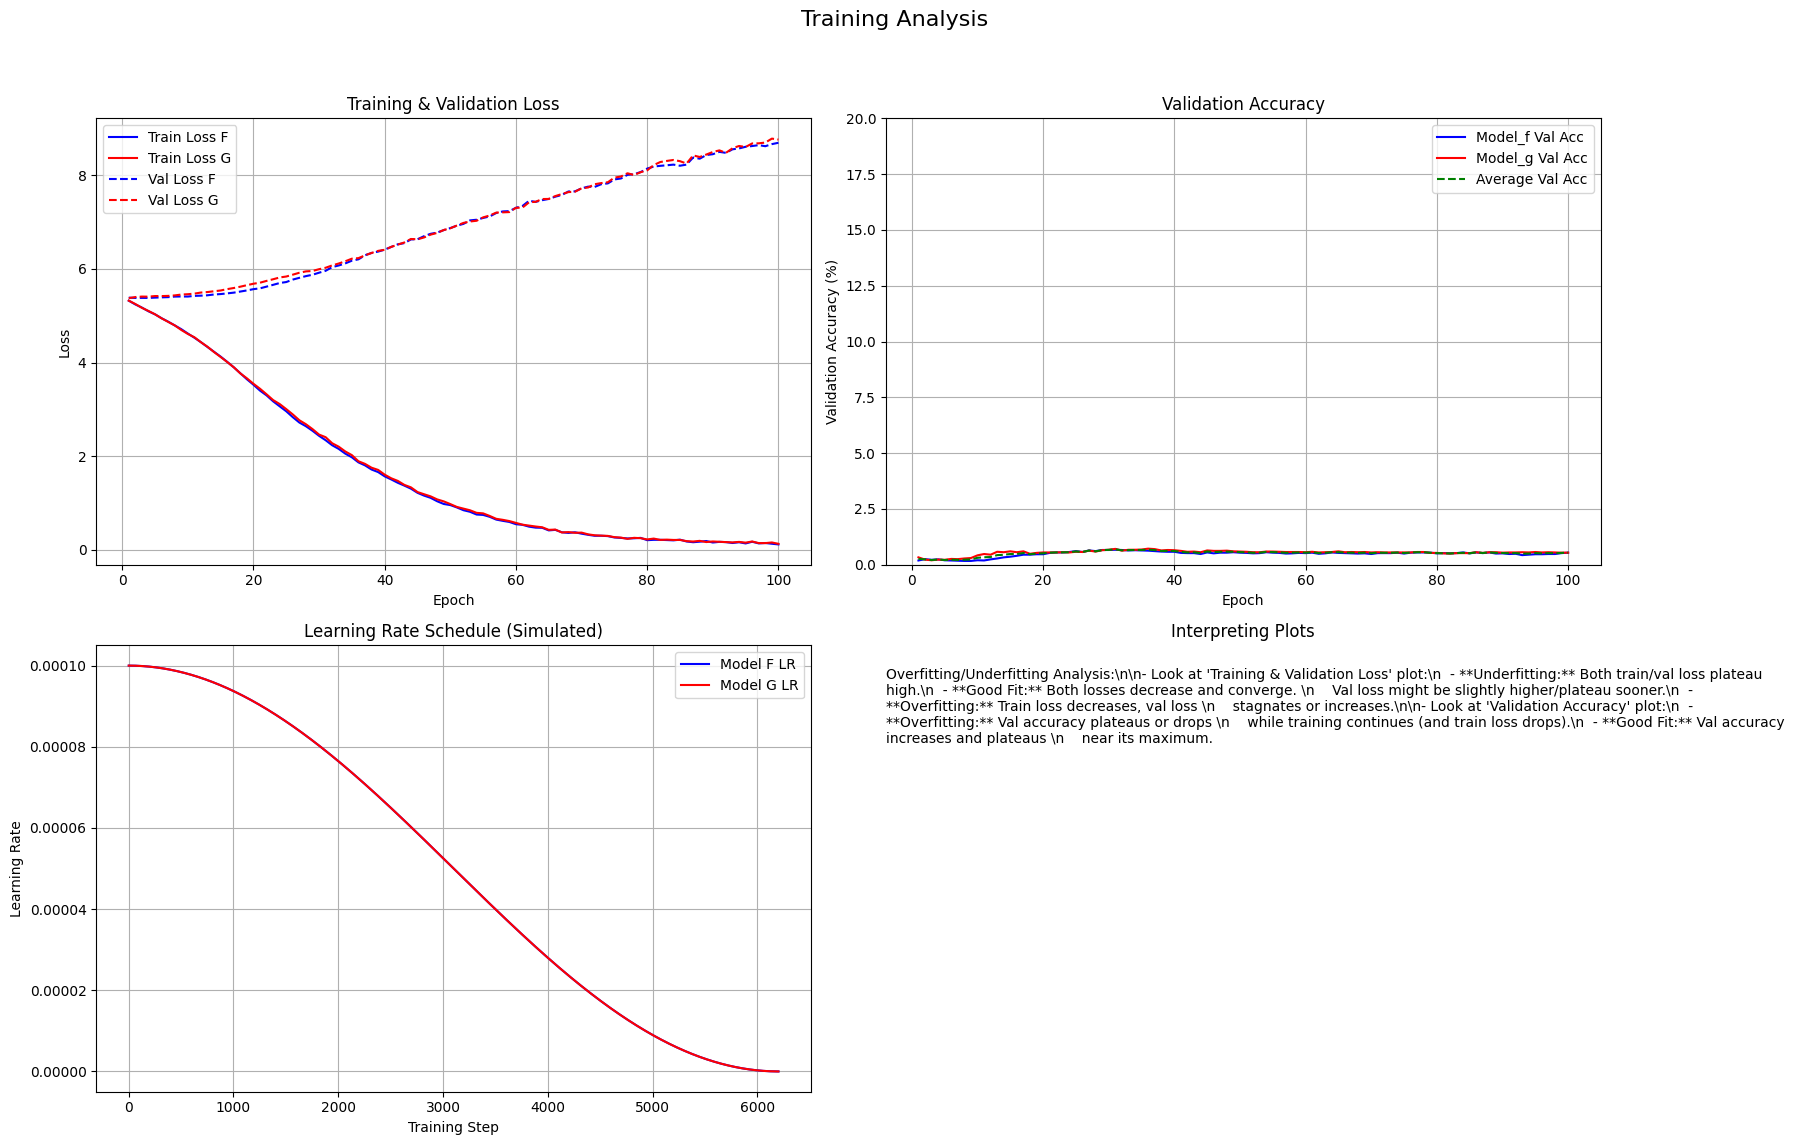

In [10]:
import matplotlib.pyplot as plt

# Ensure metrics lists are populated before plotting
if not train_losses_total_f or NUM_EPOCHS == 0: # Check if training ran
    print("Training metrics not available. Skipping plotting.")
else:
    epochs = range(1, len(train_losses_total_f) + 1) # Use actual length in case training stopped early

    plt.figure(figsize=(18, 12)) # Adjusted figure size for 4 plots
    plt.suptitle("Training Analysis", fontsize=16)

    # Plot Training and Validation Losses
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses_total_f, 'b-', label="Train Loss F")
    plt.plot(epochs, train_losses_total_g, 'r-', label="Train Loss G")
    if val_losses_f:
        plt.plot(epochs, val_losses_f, 'b--', label="Val Loss F")
    if val_losses_g:
        plt.plot(epochs, val_losses_g, 'r--', label="Val Loss G")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    # plt.ylim(bottom=0) # Optional: Set y-axis minimum

    # Plot Validation Accuracies
    plt.subplot(2, 2, 2)
    if val_accuracies_f:
        plt.plot(epochs, [acc*100 for acc in val_accuracies_f], 'b-', label="Model_f Val Acc")
    if val_accuracies_g:
        plt.plot(epochs, [acc*100 for acc in val_accuracies_g], 'r-', label="Model_g Val Acc")
    if val_accuracies_avg:
        plt.plot(epochs, [acc*100 for acc in val_accuracies_avg], 'g--', label="Average Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, max(max(val_accuracies_avg)*100 + 10, 20) if val_accuracies_avg else 20) # Adjust y-limit dynamically

    # Plot Learning Rate (Optional, assumes one optimizer group)
    plt.subplot(2, 2, 3)
    lr_history_f = []
    lr_history_g = []
    # Check if scheduler exists and has needed attributes
    if 'scheduler_f' in globals() and scheduler_f and hasattr(scheduler_f, 'state_dict'): 
        try:
            # Recreate optimizer and scheduler to get history (not ideal, store during training for perfect accuracy)
            temp_optimizer_f = optim.AdamW([torch.zeros(1)], lr=LEARNING_RATE) # Dummy parameter
            temp_scheduler_f = optim.lr_scheduler.CosineAnnealingLR(temp_optimizer_f, T_max=len(labeled_loader) * NUM_EPOCHS)
            for _ in range(len(labeled_loader) * len(epochs)): # Use actual epochs run
                lr_history_f.append(temp_optimizer_f.param_groups[0]['lr'])
                temp_scheduler_f.step()
            plt.plot(range(1, len(lr_history_f) + 1), lr_history_f, 'b-', label='Model F LR')
        except Exception as e:
             print(f"Could not plot LR history for F: {e}")

    if 'scheduler_g' in globals() and scheduler_g and hasattr(scheduler_g, 'state_dict'):
        try:
            temp_optimizer_g = optim.AdamW([torch.zeros(1)], lr=LEARNING_RATE) # Dummy parameter
            temp_scheduler_g = optim.lr_scheduler.CosineAnnealingLR(temp_optimizer_g, T_max=len(labeled_loader) * NUM_EPOCHS)
            for _ in range(len(labeled_loader) * len(epochs)): # Use actual epochs run
                lr_history_g.append(temp_optimizer_g.param_groups[0]['lr'])
                temp_scheduler_g.step()
            plt.plot(range(1, len(lr_history_g) + 1), lr_history_g, 'r-', label='Model G LR')
        except Exception as e:
             print(f"Could not plot LR history for G: {e}")

    plt.xlabel("Training Step")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule (Simulated)")
    if lr_history_f or lr_history_g: plt.legend()
    plt.grid(True)

    # Add explanation for Over/Underfitting
    plt.subplot(2, 2, 4)
    plt.axis('off') # Hide axes
    explanation = (
        "Overfitting/Underfitting Analysis:\\n\\n"
        "- Look at 'Training & Validation Loss' plot:\\n"
        "  - **Underfitting:** Both train/val loss plateau high.\\n"
        "  - **Good Fit:** Both losses decrease and converge. \\n    Val loss might be slightly higher/plateau sooner.\\n"
        "  - **Overfitting:** Train loss decreases, val loss \\n    stagnates or increases.\\n\\n"
        "- Look at 'Validation Accuracy' plot:\\n"
        "  - **Overfitting:** Val accuracy plateaus or drops \\n    while training continues (and train loss drops).\\n"
        "  - **Good Fit:** Val accuracy increases and plateaus \\n    near its maximum."
    )
    plt.text(0.0, 0.95, explanation, ha='left', va='top', fontsize=10, wrap=True)
    plt.title("Interpreting Plots")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

## 11. Final Evaluation (Using Best Models)

Load the best saved models (state dictionaries) and evaluate them individually and averaged on the validation set.

In [11]:
print("Loading best models for final evaluation...")

# Use the .pth extension used during saving
best_model_f_path = os.path.join(CHECKPOINT_DIR, "best_model_f.pth")
best_model_g_path = os.path.join(CHECKPOINT_DIR, "best_model_g.pth")

if os.path.exists(best_model_f_path) and os.path.exists(best_model_g_path):
    # Recreate model structures (make sure num_classes matches)
    print(f"Recreating models for {num_classes} classes...")
    final_model_f = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes, pretrained=False)).to(device)
    final_model_g = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes, pretrained=False)).to(device)

    # Load state dictionaries
    try:
        print(f"Loading state dict from: {best_model_f_path}")
        final_model_f.load_state_dict(torch.load(best_model_f_path, map_location=device))
        print(f"Loading state dict from: {best_model_g_path}")
        final_model_g.load_state_dict(torch.load(best_model_g_path, map_location=device))
        print("State dicts loaded successfully.")

        print("\nEvaluating Best Model F...")
        final_loss_f, final_acc_f = evaluate(final_model_f, val_loader, ce_loss)
        print(f"  Best Model F Val Loss: {final_loss_f:.4f}, Val Acc: {final_acc_f*100:.2f}%")

        print("Evaluating Best Model G...")
        final_loss_g, final_acc_g = evaluate(final_model_g, val_loader, ce_loss)
        print(f"  Best Model G Val Loss: {final_loss_g:.4f}, Val Acc: {final_acc_g*100:.2f}%")

        print(f"\nBest Average Validation Accuracy during training: {best_val_acc_avg*100:.2f}%")
        print(f"Final Average Validation Accuracy (re-evaluated): {(final_acc_f + final_acc_g)*100/2.0:.2f}%")

    except Exception as e:
        print(f"Error loading state dicts or evaluating: {e}")
        print("Ensure the model architecture matches the saved state dict and the file paths are correct.")

else:
    print(f"Best model checkpoints not found at {best_model_f_path} or {best_model_g_path}.")
    print("Cannot perform final evaluation. Ensure training completed and saved the files.")

Loading best models for final evaluation...
Recreating models for 200 classes...
Loading efficientnet-b0 without pretrained weights...
Replaced final layer for 200 classes.
Loading efficientnet-b0 without pretrained weights...
Replaced final layer for 200 classes.
Loading state dict from: jointmatch_efficientnet_checkpoints/best_model_f.pth
Loading state dict from: jointmatch_efficientnet_checkpoints/best_model_g.pth
State dicts loaded successfully.

Evaluating Best Model F...


/tmp/ipykernel_19/4279500968.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model_f.load_state_dict(torch.load(best_model_f_path, map_location=device))
/tmp/ipyk

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Best Model F Val Loss: 5.9614, Val Acc: 0.67%
Evaluating Best Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Best Model G Val Loss: 6.0264, Val Acc: 0.71%

Best Average Validation Accuracy during training: 0.69%
Final Average Validation Accuracy (re-evaluated): 0.69%


## 12. Varying Labeled Data Percentage (Conceptual)

Semi-supervised learning methods like JointMatch are particularly beneficial when labeled data is scarce. To understand the impact of the labeled data amount, one would typically run the *entire training process* multiple times, varying the number of labeled samples used in the `split_dataset` function (controlled by `NUM_LABELED_PER_CLASS` in Cell 5).

For example, you could test with `NUM_LABELED_PER_CLASS` set to values like 2, 5, 10, 25, 50, 100 (corresponding roughly to 0.4%, 1%, 2%, 5%, 10%, 20% of the Tiny ImageNet training set).

**Process:**

1.  **Loop over desired fractions:** Create an outer loop around the data splitting, model initialization, and training loop sections.
2.  **Set `NUM_LABELED_PER_CLASS`:** Inside the loop, calculate and set this value based on the target percentage.
3.  **Split Data:** Call `split_dataset`.
4.  **Create DataLoaders:** Regenerate `labeled_loader` and `unlabeled_loader`.
5.  **Initialize Models & Optimizers:** Crucially, recreate the models (`model_f`, `model_g`) and their optimizers/schedulers *from scratch* for each run to avoid leakage from previous runs.
6.  **Train:** Run the complete training loop (Cell 9).
7.  **Record Result:** Store the `best_val_acc_avg` achieved for that labeled data fraction.
8.  **Plot:** After the outer loop finishes, plot the best accuracy achieved vs. the percentage of labeled data used.

**Note:** This is computationally expensive as it involves multiple full training runs. The cell below provides a template for plotting the results, using *illustrative placeholder data*.

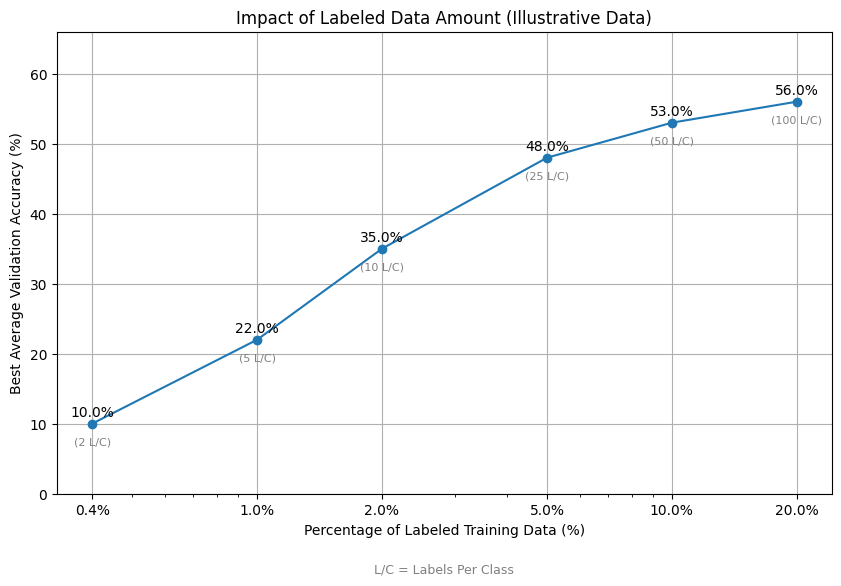


********************************************************************
*** NOTE: The above plot uses ILLUSTRATIVE placeholder data. ***
*** To generate real results, re-run the notebook multiple   ***
*** times, changing NUM_LABELED_PER_CLASS in Cell 5 each time. ***
********************************************************************


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --- Placeholder Data --- 
# This section should be replaced with actual results gathered from 
# running the full training multiple times with different NUM_LABELED_PER_CLASS.

# Example: Let's assume we tested these numbers of labeled samples per class
num_labels_per_class_tested = np.array([2, 5, 10, 25, 50, 100]) 

# Calculate corresponding percentage of total labeled data
# Tiny ImageNet: 100,000 train images, 200 classes -> 500 images/class
total_train_samples = 100000 
total_classes = 200
percentage_labeled = (num_labels_per_class_tested * total_classes) / total_train_samples * 100

# EXAMPLE BEST AVG ACCURACY ACHIEVED FOR EACH RUN (Replace with real results)
# These values are purely illustrative and depend heavily on hyperparameters, epochs, etc.
# A typical trend is rapid improvement initially, then diminishing returns.
best_avg_accuracies = np.array([ 0.10, 0.22, 0.35, 0.48, 0.53, 0.56 ]) # Fictional values!

if len(percentage_labeled) != len(best_avg_accuracies):
    print("Warning: Mismatch between number of tested percentages and accuracy results. Plot may be incorrect.")
    # Attempt to plot with the shorter length
    min_len = min(len(percentage_labeled), len(best_avg_accuracies))
    percentage_labeled = percentage_labeled[:min_len]
    best_avg_accuracies = best_avg_accuracies[:min_len]

# --- Plotting --- 
plt.figure(figsize=(10, 6))
plt.plot(percentage_labeled, best_avg_accuracies * 100, marker='o', linestyle='-')

# Add labels for each point
for i, txt in enumerate(num_labels_per_class_tested):
    plt.annotate(f'{best_avg_accuracies[i]*100:.1f}%', 
                 (percentage_labeled[i], best_avg_accuracies[i]*100), 
                 textcoords="offset points", xytext=(0,5), ha='center')
    plt.annotate(f'({txt} L/C)', 
                 (percentage_labeled[i], best_avg_accuracies[i]*100), 
                 textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='gray')

plt.xlabel("Percentage of Labeled Training Data (%)")
plt.ylabel("Best Average Validation Accuracy (%)")
plt.title("Impact of Labeled Data Amount (Illustrative Data)")
plt.grid(True)
plt.ylim(0, max(best_avg_accuracies.max()*100 + 10, 60)) # Adjust y-axis based on data
plt.xscale('log') # Log scale is common for % labeled data plots
plt.xticks(percentage_labeled, [f'{p:.1f}%' for p in percentage_labeled]) # Clearer ticks

plt.text(0.5, -0.15, 'L/C = Labels Per Class', ha='center', va='top', transform=plt.gca().transAxes, fontsize=9, color='gray')

plt.show()

print("\n********************************************************************")
print("*** NOTE: The above plot uses ILLUSTRATIVE placeholder data. ***")
print("*** To generate real results, re-run the notebook multiple   ***")
print("*** times, changing NUM_LABELED_PER_CLASS in Cell 5 each time. ***")
print("********************************************************************")